# Run this notebook on the provisional C2 server so it can access the C2 database

## Import

In [1]:
%matplotlib inline

import datacube
from datacube.testutils import io
from datacube.utils import masking
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import xarray as xr
import numpy as np
import seaborn as sns
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer

sys.path.append("../Scripts")
from deafrica_bandindices import calculate_indices
from deafrica_plotting import rgb
from deafrica_plotting import display_map
from deafrica_spatialtools import subpixel_contours
from deafrica_datahandling import wofs_fuser, mostcommon_crs

/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Viewer requires Qt
  app.launch_new_instance()


In [2]:
dc = datacube.Datacube(app="Collection2_Comparison")

In [3]:
# Calculating MNDWI for Collection 2 Level 2 :(

def calculate_mndwi_c2(ds):
    ds['MNDWI'] = (ds.green - ds.swir1)/(ds.green + ds.swir1 - 1454.54)
    return(ds)

## Level 2 Collection 2 data

### Set 2
Cloudy on L1 data but hopefully not here

In [4]:
# Define the area of interest
lat = -1.66
lon = 29.07
buffer = 0.08

#1.80574°S, 29.14666°E

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

# Shows the selected area on a map
display_map(x=lon_range, y=lat_range)

In [5]:
# Set the range of dates for the analysis
s1_time = ("2018-01-10", "2018-01-18")

# Create query for Collection 2 surface reflectance
product = ['usgs_ls8c_level2_2']
measurements = ['green','swir1', 'red', 'blue']

query = {
    "x": lon_range,
    "y": lat_range,
    "time": s1_time,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32635" #same as Level 1 data CRS
}

# Load dataset
s1_l2_data_full = dc.load(product=product, measurements = measurements, **query).squeeze()
s1_l2_data = calculate_indices(s1_l2_data_full, index = 'MNDWI', collection = 'c1') 

In [6]:
print(s1_l2_data)

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
    time         datetime64[ns] 2018-01-16T08:14:07.739591
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 29559 29651 30037 29843 ... 27977 26644 27435
    swir1        (y, x) uint16 28934 28913 29484 29653 ... 26167 24750 25212
    red          (y, x) uint16 29803 29784 30072 29736 ... 28183 26867 27723
    blue         (y, x) uint16 28577 28315 28463 27937 ... 27302 26798 27499
    MNDWI        (y, x) float64 0.01069 0.0126 0.009291 ... 0.03685 0.04222
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref


<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
    time         datetime64[ns] 2018-01-16T08:14:07.739591
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 29559 29651 30037 29843 ... 27977 26644 27435
    swir1        (y, x) uint16 28934 28913 29484 29653 ... 26167 24750 25212
    red          (y, x) uint16 29803 29784 30072 29736 ... 28183 26867 27723
    blue         (y, x) uint16 28577 28315 28463 27937 ... 27302 26798 27499
    MNDWI        (y, x) float64 0.01096 0.01292 0.009524 ... 0.03793 0.04342
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref


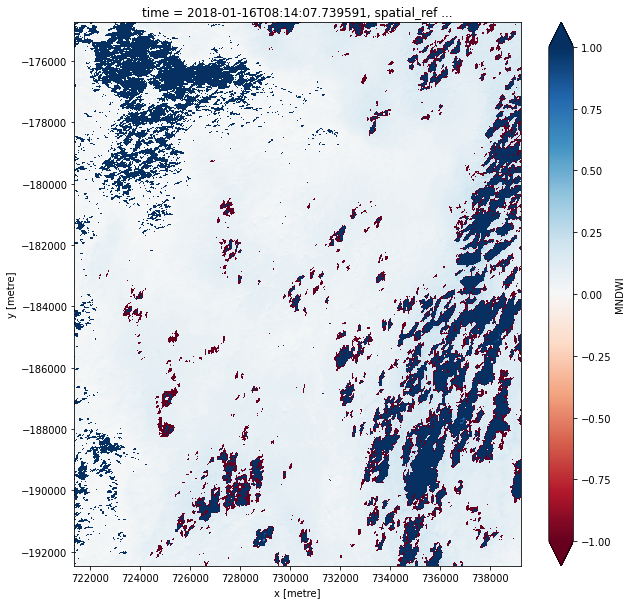

In [7]:
s1_l2_data_test = calculate_mndwi_c2(s1_l2_data)

print(s1_l2_data_test)

s1_l2_data_test.MNDWI.plot(figsize=(10,10), cmap='RdBu', vmin=-1, vmax=1)

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
    spatial_ref  int32 32635
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
    time         datetime64[ns] 2018-01-16T08:14:07.739591
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
Data variables:
    green        (y, x) float64 0.6129 0.6154 0.626 ... 0.5694 0.5327 0.5545
    swir1        (y, x) float64 0.5957 0.5951 0.6108 ... 0.5196 0.4806 0.4933
    red          (y, x) float64 0.6196 0.6191 0.627 ... 0.575 0.5388 0.5624
    blue         (y, x) float64 0.5859 0.5787 0.5827 ... 0.5508 0.5369 0.5562
    MNDWI        (y, x) float64 0.01422 0.01677 0.0123 ... 0.0514 0.05834
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref


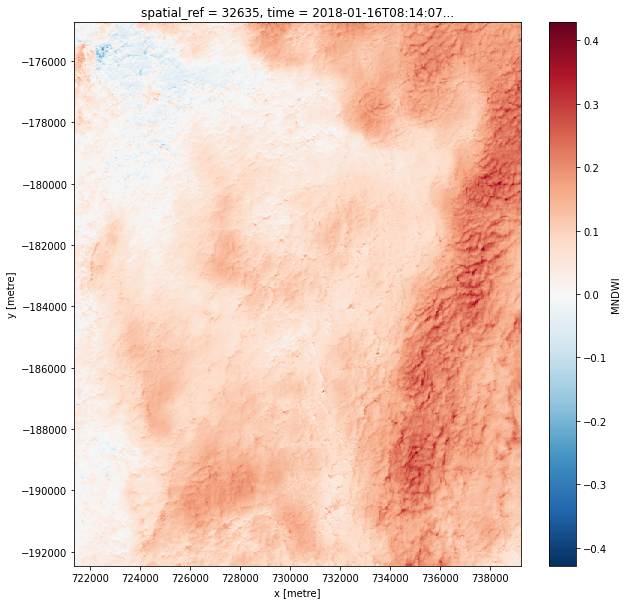

In [8]:
# try again - add corrections to dataset directly

s1_l2_data_test2 = s1_l2_data_full*2.75e-5-0.2
s1_l2_data_test2 = calculate_indices(s1_l2_data_test2, index = 'MNDWI', collection = 'c1') 

print(s1_l2_data_test2)
s1_l2_data_test2.MNDWI.plot(figsize = (10,10))

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
    time         datetime64[ns] 2018-01-16T08:14:07.739591
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 29559 29651 30037 29843 ... 27977 26644 27435
    swir1        (y, x) uint16 28934 28913 29484 29653 ... 26167 24750 25212
    red          (y, x) uint16 29803 29784 30072 29736 ... 28183 26867 27723
    blue         (y, x) uint16 28577 28315 28463 27937 ... 27302 26798 27499
    MNDWI        (y, x) float64 0.01096 0.01292 0.009524 ... 0.03793 0.04342
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref


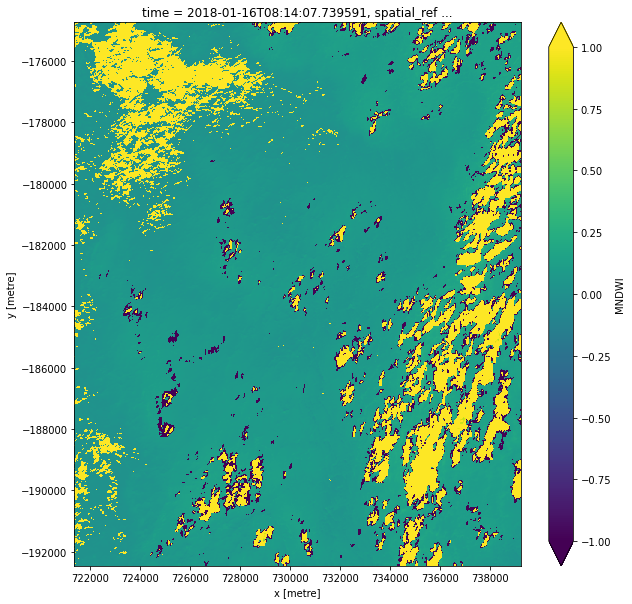

In [9]:
print(s1_l2_data)
s1_l2_data.MNDWI.plot(figsize = (10,10), vmin=-1, vmax=1)

In [10]:
# Set 2

# Set the range of dates for the analysis
s2_time = ("2018-08-01", "2018-08-12")

query = {
    "x": lon_range,
    "y": lat_range,
    "time": s2_time,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32635" #same as Level 1 data CRS
}

# Load dataset
s2_l2_data_full = dc.load(product=product, measurements = measurements, **query).squeeze()
s2_l2_data = calculate_indices(s2_l2_data_full, index = 'MNDWI', collection = 'c1') 

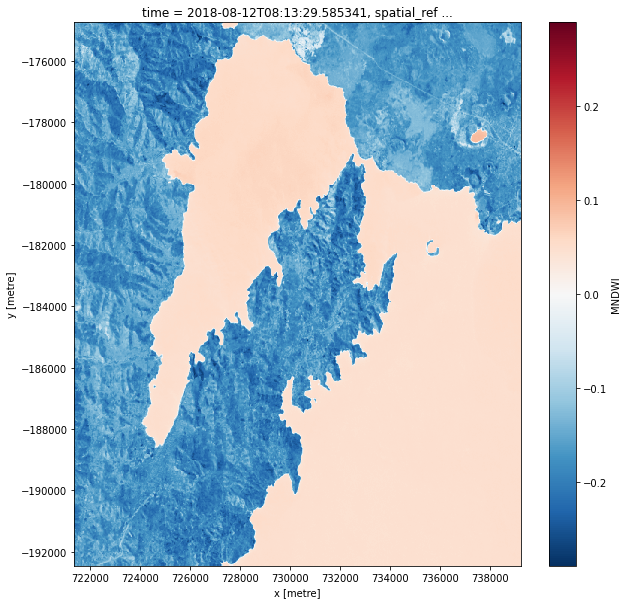

In [11]:
s2_l2_data.MNDWI.plot(figsize = (10,10))

In [12]:
# Set 5 - set 3 doesn't seem to exist

# Set the range of dates for the analysis
s5_time = ("2018-12-30", "2019-02-12")

query = {
    "x": lon_range,
    "y": lat_range,
    "time": s5_time,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32635" #same as Level 1 data CRS
}

# Load dataset
s5_l2_data_full = dc.load(product=product, measurements = measurements, **query).squeeze()
s5_l2_data = calculate_indices(s5_l2_data_full, index = 'MNDWI', collection = 'c1') 

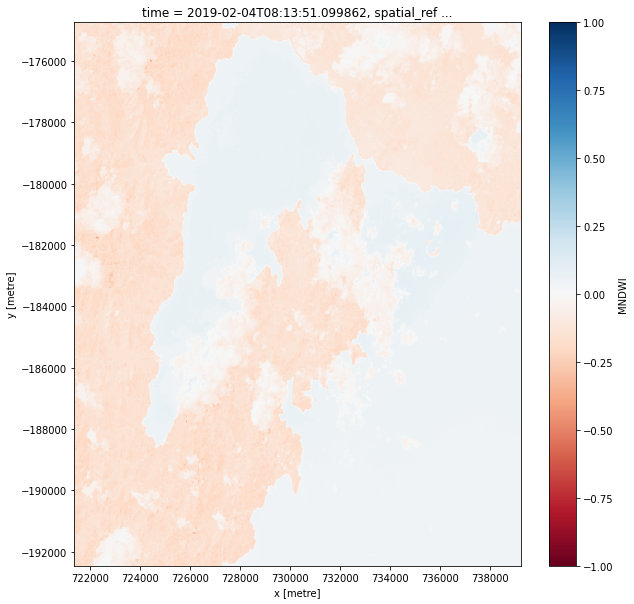

In [13]:
s5_l2_data.MNDWI.plot(figsize = (10,10), vmax=1, vmin=-1, cmap='RdBu')

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
    spatial_ref  int32 32635
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
    time         datetime64[ns] 2019-02-04T08:13:51.099862
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
Data variables:
    green        (y, x) float64 0.1115 0.08944 0.08724 ... 0.04093 0.04159
    swir1        (y, x) float64 0.213 0.1869 0.1791 ... 0.02209 0.02209 0.02223
    red          (y, x) float64 0.1068 0.08441 0.08226 ... 0.02561 0.02597
    blue         (y, x) float64 0.07489 0.05619 0.05438 ... 0.03796 0.03796
    MNDWI        (y, x) float64 -0.3129 -0.3526 -0.3449 ... 0.3023 0.2989 0.3034
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref


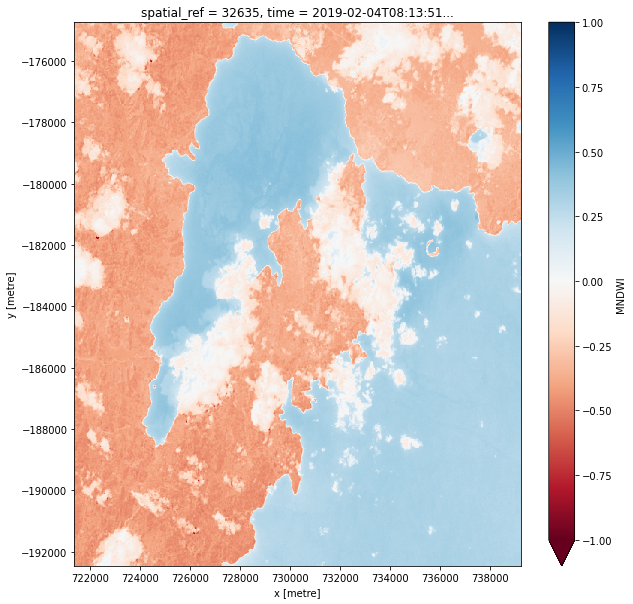

In [14]:
# Trying the corrected scale for Set 5, Collection 2 Level 2

s5_l2_data_test2 = s5_l2_data_full*2.75e-5-0.2
s5_l2_data_test2 = calculate_indices(s5_l2_data_test2, index = 'MNDWI', collection = 'c1') 

print(s5_l2_data_test2)
s5_l2_data_test2.MNDWI.plot(figsize = (10,10), vmax=1, vmin=-1, cmap='RdBu')

## Trying the Collection 1 product for Set 5

In [15]:
productc1 = ['ls8_usgs_sr_scene']

query = {
    "x": lon_range,
    "y": lat_range,
    "time": s5_time,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32635" #same as Level 1 data CRS
}

# Load dataset
c1s5_l2_data_full = dc.load(product=productc1, measurements = measurements, **query).squeeze()
c1s5_l2_data = calculate_indices(c1s5_l2_data_full, index = 'MNDWI', collection = 'c1') 

In [16]:
print(c1s5_l2_data.isel(time=2))

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
    time         datetime64[ns] 2019-02-04T08:13:51.099862
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) int16 1080 993 965 885 957 872 ... 403 404 409 412 413
    swir1        (y, x) int16 2124 2016 1947 1948 1942 ... 213 219 216 222 220
    red          (y, x) int16 1060 998 941 851 919 821 ... 243 246 249 250 253
    blue         (y, x) int16 713 652 613 551 617 537 ... 378 384 385 385 384
    MNDWI        (y, x) float64 -0.3258 -0.34 -0.3372 ... 0.3088 0.2997 0.3049
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref


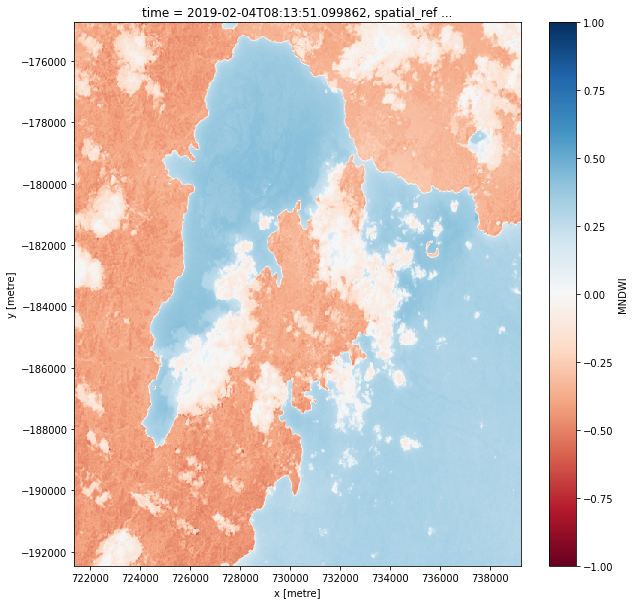

In [17]:
c1s5_l2_data.isel(time=2).MNDWI.plot(figsize = (10,10), vmax=1, vmin=-1, cmap='RdBu')

## Set 6 - cloudyish in Level 1 

In [34]:
# Set the range of dates for the analysis
s6_time = ("2018-05-05", "2018-05-10")

query = {
    "x": lon_range,
    "y": lat_range,
    "time": s6_time,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32635" #same as Level 1 data CRS
}

# Load dataset
s6_l2_data_full = dc.load(product=product, measurements = measurements, **query).squeeze()

In [35]:
print(s6_l2_data_full)

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
    time         datetime64[ns] 2018-05-08T08:13:10.820135
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 8198 8234 8348 8482 8913 ... 8459 8428 8428 8447
    swir1        (y, x) uint16 8460 8582 8750 8981 9562 ... 7911 7886 7903 7919
    red          (y, x) uint16 7998 8079 8136 8198 8673 ... 8036 7999 8032 8048
    blue         (y, x) uint16 8050 8213 8209 8181 8584 ... 8495 8455 8480 8524
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref


<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
    spatial_ref  int32 32635
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
    time         datetime64[ns] 2018-05-08T08:13:10.820135
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
Data variables:
    green        (y, x) float64 0.02544 0.02643 0.02957 ... 0.03177 0.03229
    swir1        (y, x) float64 0.03265 0.03601 0.04062 ... 0.01733 0.01777
    red          (y, x) float64 0.01994 0.02217 0.02374 ... 0.02088 0.02132
    blue         (y, x) float64 0.02138 0.02586 0.02575 ... 0.0332 0.03441
    MNDWI        (y, x) float64 -0.124 -0.1533 -0.1575 ... 0.3065 0.294 0.29
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref


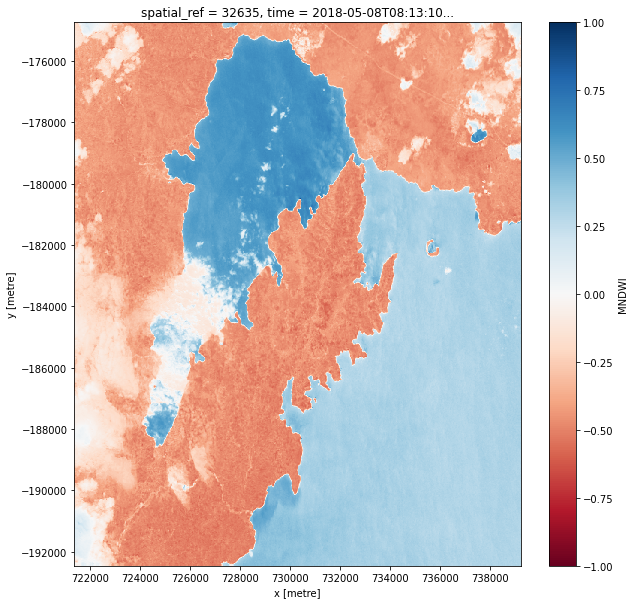

In [36]:
# Trying the corrected scale for Set 6, Collection 2 Level 2

s6_l2_data_test2 = s6_l2_data_full*2.75e-5-0.2
s6_l2_data_test2 = calculate_indices(s6_l2_data_test2, index = 'MNDWI', collection = 'c1') 

print(s6_l2_data_test2)
s6_l2_data_test2.MNDWI.plot(figsize = (10,10), vmax=1, vmin=-1, cmap='RdBu')

## Trying for a non-cloudy Level 2 but cloudy Level 1

### This is a nice plot but it is not cloudy in both L1 and L2

You have this tiff saved from S3

In [18]:
gb_time = ("2018-01-05", "2018-01-12")
gb_lat = 12.035
gb_lon = -15.97
#buffer is same as other C2 L2 imports

gb_lat_range = (gb_lat-buffer, gb_lat+buffer)
gb_lon_range = (gb_lon-buffer, gb_lon+buffer)

query = {
    "x": gb_lon_range,
    "y": gb_lat_range,
    "time": gb_time,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32635" #same as Level 1 data CRS
}

# Load dataset
gb_l2_data_full = dc.load(product=product, measurements = measurements, **query)
gb_l2_data_full = gb_l2_data_full.isel(time=1).squeeze()
gb_l2_data_full = gb_l2_data_full*2.75e-5-0.2 #add corrections
gb_l2_data = calculate_indices(gb_l2_data_full, index = 'MNDWI', collection = 'c1') 

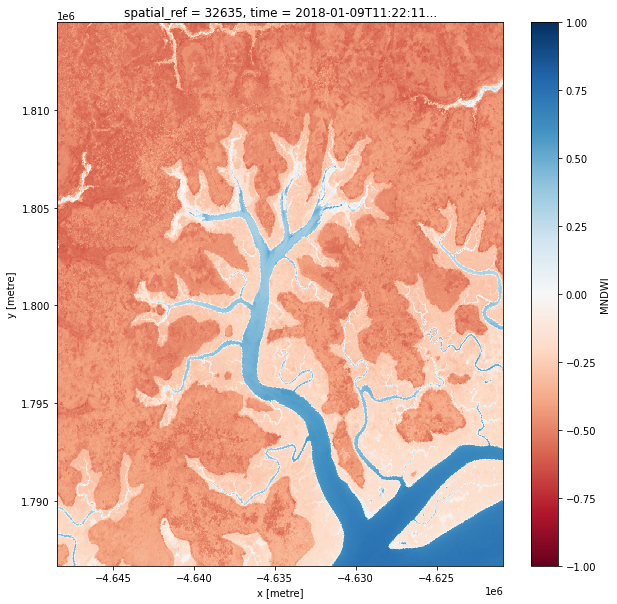

In [19]:
gb_l2_data.MNDWI.plot(figsize=(10,10), cmap='RdBu', vmax = 1, vmin=-1)

### Let's try 12 Jan 2019 

In [20]:
gb2_time = ("2019-01-05", "2019-01-15")

query = {
    "x": gb_lon_range,
    "y": gb_lat_range,
    "time": gb2_time,
    'resolution':(-30,30),
    'align':(15,15),
    'output_crs':"EPSG:32635" #same as Level 1 data CRS
}

# Load dataset using C2 L2
gb2_l2_data_full = dc.load(product=product, measurements = measurements, **query)
gb2_l2_data_full = gb2_l2_data_full.isel(time=1).squeeze()
gb2_l2_data_full = gb2_l2_data_full*2.75e-5-0.2 #add corrections
gb2_l2_data = calculate_indices(gb2_l2_data_full, index = 'MNDWI', collection = 'c1') 

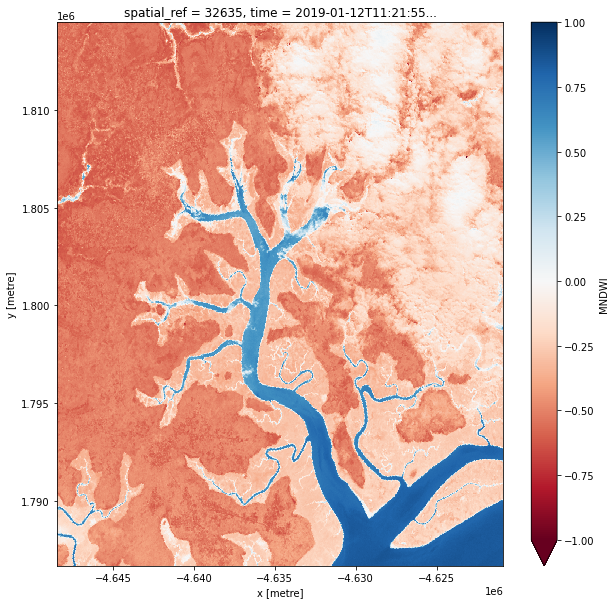

In [21]:
gb2_l2_data.MNDWI.plot(figsize=(10,10), cmap='RdBu', vmax = 1, vmin=-1)

## Generating x-y coordinates for the Collection 1 notebook
### Set 1

In [22]:
print(s1_l2_data.x.values[0], s1_l2_data.x.values[-1], s1_l2_data.y.values[0], s1_l2_data.y.values[-1])

721380.0 739200.0 -174750.0 -192450.0


# Import L1 datasets which were exported as  geotiffs

In [23]:
s1_l1_green = io.rio_slurp_xarray('s1_l1_green.tif')
s1_l1_swir1 =  io.rio_slurp_xarray('s1_l1_swir1.tif')

s1_l1_data_full = s1_l1_green.to_dataset(name = 'green')
s1_l1_data_full['swir1'] = s1_l1_swir1

# Selects the L1 data that corresponds to the same area as the L2 data
s1_l1_data = s1_l1_data_full.sel(x = slice(s1_l2_data.x.values[0], s1_l2_data.x.values[-1]), y = slice(s1_l2_data.y.values[0], s1_l2_data.y.values[-1]))
s1_l1_data = calculate_indices(s1_l1_data, index = 'MNDWI', collection = 'c1') 
print(s1_l1_data)

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 29704 29935 30390 29897 ... 25682 26045 26914
    swir1        (y, x) uint16 29052 28935 29620 29625 ... 24398 24014 24923
    MNDWI        (y, x) float64 0.0111 0.01699 0.01283 ... 0.04057 0.03841


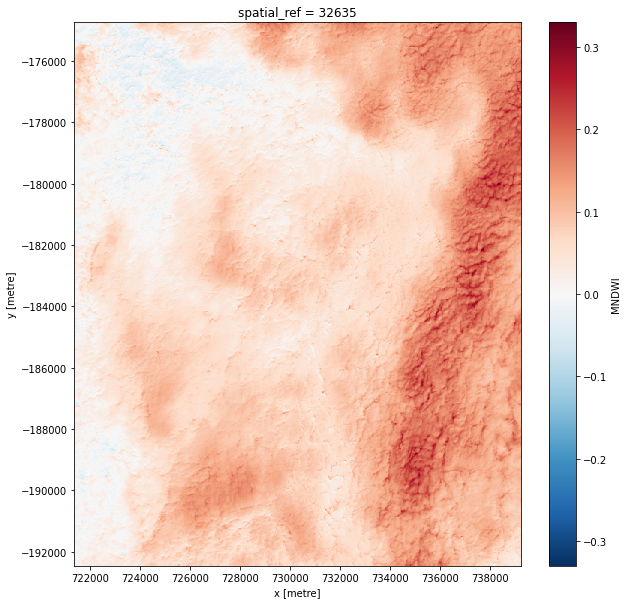

In [24]:
s1_l1_data.MNDWI.plot(figsize=(10,10))

In [25]:
s2_l1_green = io.rio_slurp_xarray('s2_l1_green.tif')
s2_l1_swir1 =  io.rio_slurp_xarray('s2_l1_swir1.tif')

s2_l1_data_full = s2_l1_green.to_dataset(name = 'green')
s2_l1_data_full['swir1'] = s2_l1_swir1

# Selects the L1 data that corresponds to the same area as the L2 data
s2_l1_data = s2_l1_data_full.sel(x = slice(s1_l2_data.x.values[0], s1_l2_data.x.values[-1]), y = slice(s1_l2_data.y.values[0], s1_l2_data.y.values[-1]))
s2_l1_data = calculate_indices(s2_l1_data, index = 'MNDWI', collection = 'c1') 
print(s2_l1_data)

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 8958 8788 8566 8630 8804 ... 7824 7822 7834 7848
    swir1        (y, x) uint16 10968 10676 10235 10090 ... 5480 5482 5486 5504
    MNDWI        (y, x) float64 -0.1009 -0.097 -0.08877 ... 0.1759 0.1763 0.1756


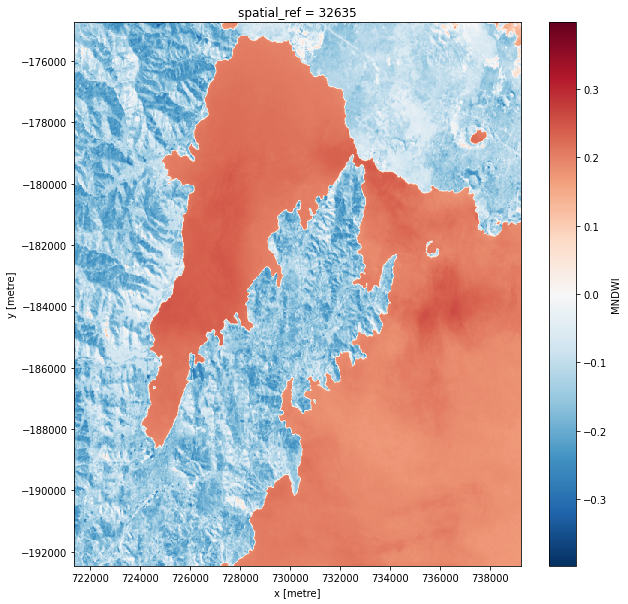

In [26]:
s2_l1_data.MNDWI.plot(figsize=(10,10))

In [27]:
s3_l1_green = io.rio_slurp_xarray('s3_l1_green.tif')
s3_l1_swir1 =  io.rio_slurp_xarray('s3_l1_swir1.tif')

s3_l1_data_full = s3_l1_green.to_dataset(name = 'green')
s3_l1_data_full['swir1'] = s3_l1_swir1

# Selects the L1 data that corresponds to the same area as the L2 data
s3_l1_data = s3_l1_data_full.sel(x = slice(s1_l2_data.x.values[0], s1_l2_data.x.values[-1]), y = slice(s1_l2_data.y.values[0], s1_l2_data.y.values[-1]))
s3_l1_data = calculate_indices(s3_l1_data, index = 'MNDWI', collection = 'c1') 
print(s3_l1_data)

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 20134 20082 20407 20242 ... 7978 7989 7992 8013
    swir1        (y, x) uint16 22493 22047 22497 22267 ... 5417 5430 5439 5452
    MNDWI        (y, x) float64 -0.05534 -0.04664 -0.04871 ... 0.1901 0.1902


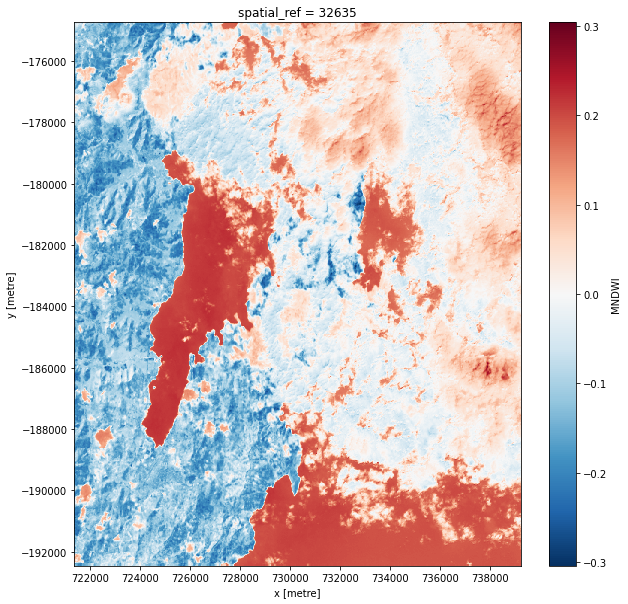

In [28]:
s3_l1_data.MNDWI.plot(figsize=(10,10))

In [29]:
s4_l1_green = io.rio_slurp_xarray('s4_l1_green.tif')
s4_l1_swir1 =  io.rio_slurp_xarray('s4_l1_swir1.tif')

s4_l1_data_full = s4_l1_green.to_dataset(name = 'green')
s4_l1_data_full['swir1'] = s4_l1_swir1

# Selects the L1 data that corresponds to the same area as the L2 data
s4_l1_data = s4_l1_data_full.sel(x = slice(s1_l2_data.x.values[0], s1_l2_data.x.values[-1]), y = slice(s1_l2_data.y.values[0], s1_l2_data.y.values[-1]))
s4_l1_data = calculate_indices(s4_l1_data, index = 'MNDWI', collection = 'c1') 
print(s4_l1_data)

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 10164 9992 9922 9951 ... 9210 9203 9193 9188
    swir1        (y, x) uint16 12407 12136 11784 11870 ... 6173 6178 6160 6164
    MNDWI        (y, x) float64 -0.09938 -0.09689 -0.08578 ... 0.1976 0.197


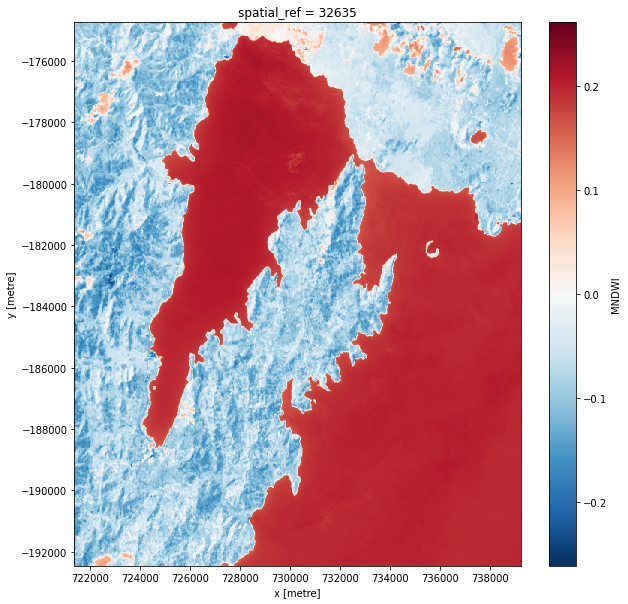

In [30]:
s4_l1_data.MNDWI.plot(figsize=(10,10))

In [31]:
s5_l1_green = io.rio_slurp_xarray('s5_l1_green.tif')
s5_l1_swir1 =  io.rio_slurp_xarray('s5_l1_swir1.tif')

s5_l1_data_full = s5_l1_green.to_dataset(name = 'green')
s5_l1_data_full['swir1'] = s5_l1_swir1

# Selects the L1 data that corresponds to the same area as the L2 data
s5_l1_data = s5_l1_data_full.sel(x = slice(s1_l2_data.x.values[0], s1_l2_data.x.values[-1]), y = slice(s1_l2_data.y.values[0], s1_l2_data.y.values[-1]))
s5_l1_data = calculate_indices(s5_l1_data, index = 'MNDWI', collection = 'c1') 
print(s5_l1_data)

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 10429 10084 10010 9760 ... 8371 8387 8398 8399
    swir1        (y, x) uint16 13582 13147 12867 12870 ... 6086 6080 6100 6092
    MNDWI        (y, x) float64 -0.1313 -0.1318 -0.1249 ... 0.1595 0.1585 0.1592


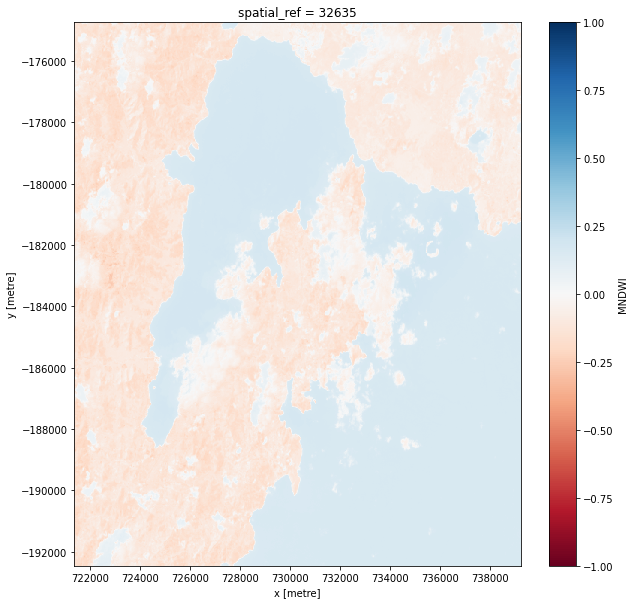

In [32]:
s5_l1_data.MNDWI.plot(figsize=(10,10), vmax=1, vmin=-1, cmap='RdBu')

<xarray.Dataset>
Dimensions:      (x: 595, y: 591)
Coordinates:
  * y            (y) float64 -1.748e+05 -1.748e+05 ... -1.924e+05 -1.924e+05
  * x            (x) float64 7.214e+05 7.214e+05 ... 7.392e+05 7.392e+05
    spatial_ref  int32 32635
Data variables:
    green        (y, x) uint16 27813 26039 26795 27356 ... 8713 8890 9134 9061
    swir1        (y, x) uint16 21699 20106 21597 22046 ... 7330 7366 7784 7934
    MNDWI        (y, x) float64 0.1235 0.1286 0.1074 ... 0.09375 0.0798 0.06631


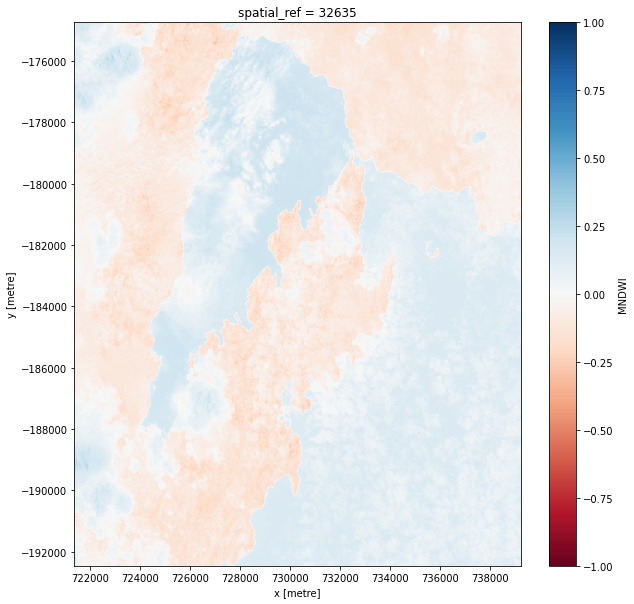

In [33]:
s6_l1_green = io.rio_slurp_xarray('s6_l1_green.tif')
s6_l1_swir1 =  io.rio_slurp_xarray('s6_l1_swir1.tif')

s6_l1_data_full = s6_l1_green.to_dataset(name = 'green')
s6_l1_data_full['swir1'] = s6_l1_swir1

# Selects the L1 data that corresponds to the same area as the L2 data
s6_l1_data = s6_l1_data_full.sel(x = slice(s1_l2_data.x.values[0], s1_l2_data.x.values[-1]), y = slice(s1_l2_data.y.values[0], s1_l2_data.y.values[-1]))
s6_l1_data = calculate_indices(s6_l1_data, index = 'MNDWI', collection = 'c1') 
print(s6_l1_data)

s6_l1_data.MNDWI.plot(figsize=(10,10), vmax=1, vmin=-1, cmap='RdBu')